# Dependencies

In [1]:
import torch 
import torch.nn as nn
import torchvision.datasets as datasets 
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pylab import *
import torchvision.transforms.functional as F


In [2]:
print(torch.__version__)  # Apparently a bug in this code which breaks my test run 

1.0.0


In [3]:
# The images are already in GrayScale form . The dimensions are also pre done .We normalize it for NN .
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
# Loading Datasets 
train_dataset = datasets.FashionMNIST(root='./data', 
                            train=True, 
                            download=True,
                            transform=transform)

test_dataset = datasets.FashionMNIST(root='./data', 
                           train=False, 
                           download=True,
                           transform=transform)

In [4]:
# Hyper parameter (1) Play around with batch size to observe the performance 
#batch_size = [x for x in range(10,110,10)]
learning_rate = [0.001,0.01]
drop_out = [0.2,0.5]
num_epochs = 10

In [5]:
#Loading dataset into dataloader. Make sure you set shuffle =False in test set . 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=32, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=32, 
                                          shuffle=False)

In [6]:
test_dataset[0][0]   # image look up 
test_dataset[0][0].shape

torch.Size([1, 28, 28])

In [7]:
# label lookup , single scalar [0,1,2,3,4,5,6,7,8,9]
type(test_loader)
len(test_dataset)
b = test_dataset[0][1]

b.shape   # here it measns zero dim tensor/scalar

torch.Size([])

In [8]:
def plot_img(image):
    image = image.numpy()[0]
    mean = 0.5
    std = 0.5
    image = ((mean*image) + std)
    plt.imshow(image,cmap='gray')

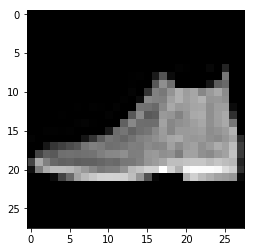

In [9]:
plot_img(test_dataset[0][0])    # test data is fine 

torch.Size([32])
torch.Size([32, 1, 28, 28])


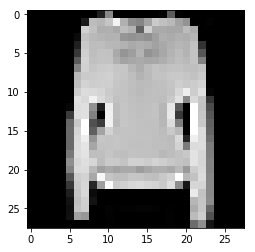

In [10]:
sample_data = next(iter(train_loader))   # 32 members being loaded 
plot_img(sample_data[0][14])
print (sample_data[1].shape)  #True Labels y
print (sample_data[0].shape)  # Train Images 32 per batch 

torch.Size([32])
tensor(8)
torch.Size([32, 1, 28, 28])


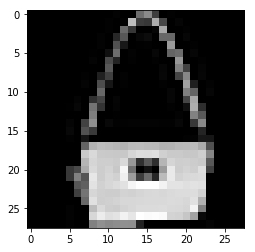

In [11]:
# Visualize few images to see how they came from test set 
sample_data_from_test = next(iter(test_loader))  # 32 members being loaded 
plot_img(sample_data_from_test[0][31])  # plotting the 32st image in the batch_size of 32 images 
print (sample_data_from_test[1].shape)  #True Labels size which are 32 labels per batch , confusing I know 
print (sample_data_from_test[1][31])   # this is the true lable of the 32st image in the test_loader 
print (sample_data_from_test[0].shape)  # Train Images 32 per batch 

In [12]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

# I am inspecting train_dataset that contains Image tensors and label tensors 

In [13]:
type(train_dataset)

torchvision.datasets.mnist.FashionMNIST

In [14]:
len(train_dataset)

60000

In [15]:
print (train_dataset[4000][0][-1][-1]) # only height, width is shown here 
print (train_dataset[4000][0].shape)

tensor([-1.0000, -1.0000, -1.0000, -0.5608, -0.2627, -0.0588, -0.0667, -0.0039,
         0.0510,  0.1373,  0.1765,  0.1843,  0.2392,  0.2471,  0.2941,  0.3255,
         0.2627,  0.1765,  0.1451,  0.0667,  0.0039,  0.0902,  0.0118, -0.2549,
        -0.9451, -1.0000, -1.0000, -1.0000])
torch.Size([1, 28, 28])


In [16]:
train_dataset[4000][1]  # this is actually a scalar value as it is label . zero dimension 

tensor(8)

In [17]:
type(train_dataset)

torchvision.datasets.mnist.FashionMNIST

In [18]:
type(train_dataset[4000])

tuple

In [19]:
img,label = train_dataset[2]

In [20]:
type(img)

torch.Tensor

In [21]:
img.shape

torch.Size([1, 28, 28])

In [22]:
#Tensor to PIL .. from PyTorch forum , I just wanted to look at an image, It is not straigtforward 

In [23]:
img = torch.FloatTensor(1, 28, 28)  # we converted into float tesnsor 

In [24]:
img = F.to_pil_image(img)  # converted float tensor to PIL format 

In [25]:
type(img)

PIL.Image.Image

In [26]:
len(train_dataset)

60000

In [27]:
type(train_dataset)

torchvision.datasets.mnist.FashionMNIST

In [28]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};

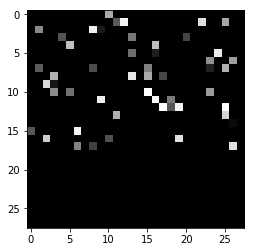

In [29]:
import matplotlib.pyplot  as plt

plt.imshow(img)
plt.show()

In [30]:
len(train_dataset)

60000

In [31]:
len(test_dataset)

10000

# Create the classifier. 


In [32]:
class Net (nn.Module):
    def __init__(self):
        super() .__init__()
        # Convolution layer 1
        self.conv1 = nn.Conv2d(1,32,5,1,1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        #Convolution layer 2
        self.conv2 = nn.Conv2d(32,64,5,1,1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # Drop out before flatten
        self.dropout = nn.Dropout(p=0.5)
        # fully connected layers 
        self.fc1 = nn.Linear(1600,500)
        self.fc2 = nn.Linear(500,10)
    def forward (self,x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        # Moving the input tensors to next convolution layer 
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        
        out = out.view(out.size(0),-1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
        

In [33]:
print (Net)

<class '__main__.Net'>


In [34]:
my_model = Net()

In [35]:
print (my_model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5)
  (fc1): Linear(in_features=1600, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate[0]);  # play around with lr 


In [37]:
losses = [ ]

In [38]:
# Training my_model to recognize the classes of my fashion clothing 
iter = 0
for epoch in range(num_epochs):
    for idex,(images,labels) in enumerate(train_loader):
        """ I am creating index location and tuple of the image/label pair here """
        images = Variable(images)
        labels = Variable(labels)
        # Ititialize the gradiant to zero, after every epoch iteration . 
        optimizer.zero_grad()
        # Calculate yhat using yhat = wx + b in the forward propagation
        outputs = my_model(images)
        # Find the loss function , which compares the true label to the predicted label from my_model
        loss = criterion(outputs,labels)
        # Re assigns the weights to the tensors and propagates backwards to the beginning 
        loss.backward()
        # Actual updates of weights happens here 
        optimizer.step()
        
        # Increment iteration 
        iter+=1
        # Total number of labels scalar value ndim=0
        total = labels.size(0)
        # Getting predictions from max value 
        
        _, predicted = torch.max(outputs.data,1)
        # calculate correct number of predictions 
        correct = (predicted == labels).sum().item()
        
        
        if (idex+1) % 32 == 0:
            print ('Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch +1,num_epochs,idex+1,len(train_loader),loss.item(),(correct /total)*100))
            
            
            
            

Epoch [1/10], Step[32/1875], Loss: 0.6485, Accuracy: 75.00%
Epoch [1/10], Step[64/1875], Loss: 0.6778, Accuracy: 71.88%
Epoch [1/10], Step[96/1875], Loss: 0.4256, Accuracy: 90.62%
Epoch [1/10], Step[128/1875], Loss: 0.4726, Accuracy: 81.25%
Epoch [1/10], Step[160/1875], Loss: 0.5682, Accuracy: 81.25%
Epoch [1/10], Step[192/1875], Loss: 0.6715, Accuracy: 75.00%
Epoch [1/10], Step[224/1875], Loss: 0.5674, Accuracy: 78.12%
Epoch [1/10], Step[256/1875], Loss: 0.4687, Accuracy: 84.38%
Epoch [1/10], Step[288/1875], Loss: 0.6105, Accuracy: 75.00%
Epoch [1/10], Step[320/1875], Loss: 0.4920, Accuracy: 78.12%
Epoch [1/10], Step[352/1875], Loss: 0.6144, Accuracy: 81.25%
Epoch [1/10], Step[384/1875], Loss: 0.3576, Accuracy: 84.38%
Epoch [1/10], Step[416/1875], Loss: 0.4376, Accuracy: 81.25%
Epoch [1/10], Step[448/1875], Loss: 0.6133, Accuracy: 71.88%
Epoch [1/10], Step[480/1875], Loss: 0.6873, Accuracy: 75.00%
Epoch [1/10], Step[512/1875], Loss: 0.2187, Accuracy: 96.88%
Epoch [1/10], Step[544/1875

Epoch [3/10], Step[608/1875], Loss: 0.2957, Accuracy: 90.62%
Epoch [3/10], Step[640/1875], Loss: 0.2664, Accuracy: 87.50%
Epoch [3/10], Step[672/1875], Loss: 0.4628, Accuracy: 90.62%
Epoch [3/10], Step[704/1875], Loss: 0.2831, Accuracy: 90.62%
Epoch [3/10], Step[736/1875], Loss: 0.2035, Accuracy: 93.75%
Epoch [3/10], Step[768/1875], Loss: 0.3713, Accuracy: 90.62%
Epoch [3/10], Step[800/1875], Loss: 0.4419, Accuracy: 87.50%
Epoch [3/10], Step[832/1875], Loss: 0.3311, Accuracy: 81.25%
Epoch [3/10], Step[864/1875], Loss: 0.2552, Accuracy: 90.62%
Epoch [3/10], Step[896/1875], Loss: 0.1904, Accuracy: 90.62%
Epoch [3/10], Step[928/1875], Loss: 0.7169, Accuracy: 84.38%
Epoch [3/10], Step[960/1875], Loss: 0.3692, Accuracy: 87.50%
Epoch [3/10], Step[992/1875], Loss: 0.4559, Accuracy: 90.62%
Epoch [3/10], Step[1024/1875], Loss: 0.1972, Accuracy: 93.75%
Epoch [3/10], Step[1056/1875], Loss: 0.1895, Accuracy: 96.88%
Epoch [3/10], Step[1088/1875], Loss: 0.3562, Accuracy: 84.38%
Epoch [3/10], Step[11

Epoch [5/10], Step[1184/1875], Loss: 0.3195, Accuracy: 87.50%
Epoch [5/10], Step[1216/1875], Loss: 0.5757, Accuracy: 81.25%
Epoch [5/10], Step[1248/1875], Loss: 0.1489, Accuracy: 90.62%
Epoch [5/10], Step[1280/1875], Loss: 0.0845, Accuracy: 96.88%
Epoch [5/10], Step[1312/1875], Loss: 0.5149, Accuracy: 87.50%
Epoch [5/10], Step[1344/1875], Loss: 0.2972, Accuracy: 93.75%
Epoch [5/10], Step[1376/1875], Loss: 0.3965, Accuracy: 90.62%
Epoch [5/10], Step[1408/1875], Loss: 0.2202, Accuracy: 90.62%
Epoch [5/10], Step[1440/1875], Loss: 0.1970, Accuracy: 93.75%
Epoch [5/10], Step[1472/1875], Loss: 0.1546, Accuracy: 93.75%
Epoch [5/10], Step[1504/1875], Loss: 0.2979, Accuracy: 84.38%
Epoch [5/10], Step[1536/1875], Loss: 0.4531, Accuracy: 90.62%
Epoch [5/10], Step[1568/1875], Loss: 0.4348, Accuracy: 84.38%
Epoch [5/10], Step[1600/1875], Loss: 0.3240, Accuracy: 87.50%
Epoch [5/10], Step[1632/1875], Loss: 0.1874, Accuracy: 90.62%
Epoch [5/10], Step[1664/1875], Loss: 0.3103, Accuracy: 87.50%
Epoch [5

Epoch [7/10], Step[1760/1875], Loss: 0.1527, Accuracy: 93.75%
Epoch [7/10], Step[1792/1875], Loss: 0.2347, Accuracy: 90.62%
Epoch [7/10], Step[1824/1875], Loss: 0.2329, Accuracy: 87.50%
Epoch [7/10], Step[1856/1875], Loss: 0.4205, Accuracy: 84.38%
Epoch [8/10], Step[32/1875], Loss: 0.2102, Accuracy: 96.88%
Epoch [8/10], Step[64/1875], Loss: 0.4551, Accuracy: 81.25%
Epoch [8/10], Step[96/1875], Loss: 0.4468, Accuracy: 81.25%
Epoch [8/10], Step[128/1875], Loss: 0.3351, Accuracy: 90.62%
Epoch [8/10], Step[160/1875], Loss: 0.1324, Accuracy: 90.62%
Epoch [8/10], Step[192/1875], Loss: 0.0524, Accuracy: 100.00%
Epoch [8/10], Step[224/1875], Loss: 0.3790, Accuracy: 84.38%
Epoch [8/10], Step[256/1875], Loss: 0.5149, Accuracy: 78.12%
Epoch [8/10], Step[288/1875], Loss: 0.1674, Accuracy: 93.75%
Epoch [8/10], Step[320/1875], Loss: 0.2301, Accuracy: 90.62%
Epoch [8/10], Step[352/1875], Loss: 0.6216, Accuracy: 87.50%
Epoch [8/10], Step[384/1875], Loss: 0.4798, Accuracy: 75.00%
Epoch [8/10], Step[416

Epoch [10/10], Step[480/1875], Loss: 0.2345, Accuracy: 90.62%
Epoch [10/10], Step[512/1875], Loss: 0.3814, Accuracy: 87.50%
Epoch [10/10], Step[544/1875], Loss: 0.2024, Accuracy: 87.50%
Epoch [10/10], Step[576/1875], Loss: 0.6622, Accuracy: 87.50%
Epoch [10/10], Step[608/1875], Loss: 0.1644, Accuracy: 93.75%
Epoch [10/10], Step[640/1875], Loss: 0.2603, Accuracy: 90.62%
Epoch [10/10], Step[672/1875], Loss: 0.2254, Accuracy: 87.50%
Epoch [10/10], Step[704/1875], Loss: 0.1833, Accuracy: 93.75%
Epoch [10/10], Step[736/1875], Loss: 0.1366, Accuracy: 96.88%
Epoch [10/10], Step[768/1875], Loss: 0.3893, Accuracy: 81.25%
Epoch [10/10], Step[800/1875], Loss: 0.2382, Accuracy: 93.75%
Epoch [10/10], Step[832/1875], Loss: 0.0928, Accuracy: 96.88%
Epoch [10/10], Step[864/1875], Loss: 0.2102, Accuracy: 93.75%
Epoch [10/10], Step[896/1875], Loss: 0.2698, Accuracy: 90.62%
Epoch [10/10], Step[928/1875], Loss: 0.4321, Accuracy: 84.38%
Epoch [10/10], Step[960/1875], Loss: 0.4124, Accuracy: 87.50%
Epoch [1

# The accoracy of the model on the training data is :
Epoch [10/10], Step[1792/1875], Loss: 0.2921, Accuracy: 87.50%
Epoch [10/10], Step[1824/1875], Loss: 0.5784, Accuracy: 84.38%
Epoch [10/10], Step[1856/1875], Loss: 0.0870, Accuracy: 96.88%     This when I ran on 19th 2019 January.
same version on the 22nd 
gave these results Strange!
Epoch [10/10], Step[1792/1875], Loss: 0.3304, Accuracy: 93.75%
Epoch [10/10], Step[1824/1875], Loss: 0.1693, Accuracy: 93.75%
Epoch [10/10], Step[1856/1875], Loss: 0.1154, Accuracy: 93.75%

# Testing my_model on test data . How does my model perform on more generalized data that it has never been exposed to ! let's find out 

In [45]:
# we donot want the model to update weights , as it is testing mode
with torch.no_grad():
    correct = 0
    total = 0
    for i,(images,labels) in  enumerate(test_loader):
        print (i,images,labels)
        images = Variable(images)
        labels = Variable(labels)
        output = my_model(images)
        _, predicted = torch.max(outputs[0:16].data,1)
        total+=labels[0:16].size(0)
        correct += (predicted == labels[0:16]).sum().item()   # This is a dictionary so make sure you get the pair 
        
        print ('My model test accoracy on the 10,000 fashion MNIST images : {} %'.format(100*correct/total))
           
print ("Images in the batch len(images)", len(images))          
print ("Labels in the batch len(labels)",len(labels))
print ("Correct labels",correct)
print ("Total labels",total)
           
           
           

0 tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0

13 tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -0.1686, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ...,  0.2078, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.

My model test accoracy on the 10,000 fashion MNIST images : 9.75 %
25 tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -0.8745, -1.0000, -0.9922],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -0.9843, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9843, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ...,  0.1451, -0.6314, -1.0000],
          [-1.0000, -1.0000, -0.9843,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -0.9922,  ..., -1.0000, -0.9922, -1.0000]]],


        [[[-1.0000, -1.0000,

38 tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1

51 tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.

64 tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.

My model test accoracy on the 10,000 fashion MNIST images : 10.256410256410257 %
78 tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.

My model test accoracy on the 10,000 fashion MNIST images : 9.782608695652174 %
92 tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]

My model test accoracy on the 10,000 fashion MNIST images : 9.316037735849056 %
106 tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.

119 tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-

My model test accoracy on the 10,000 fashion MNIST images : 9.492481203007518 %
133 tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.

146 tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-

My model test accoracy on the 10,000 fashion MNIST images : 9.21875 %
160 tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0

My model test accoracy on the 10,000 fashion MNIST images : 9.123563218390805 %
174 tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]

187 tensor([[[[-1.0000, -1.0000, -0.9765,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -0.7804,  ..., -0.0039, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.0275, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.2784, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1

My model test accoracy on the 10,000 fashion MNIST images : 9.14179104477612 %
201 tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0

My model test accoracy on the 10,000 fashion MNIST images : 9.505813953488373 %
215 tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -0.8118, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.7961, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9529, -1.0000, -1.0000]]],


        [[[-1.

My model test accoracy on the 10,000 fashion MNIST images : 9.661572052401747 %
229 tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.

242 tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.1765, -0.8118, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ...,  1.0000,  0.1137, -1.0000],
          ...,
          [-1.0000, -0.1686,  0.6784,  ..., -0.1922, -0.8353, -1.0000],
          [-1.0000,  0.3804,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9843, -0.9765, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1

My model test accoracy on the 10,000 fashion MNIST images : 9.4970703125 %
256 tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000,

My model test accoracy on the 10,000 fashion MNIST images : 9.398148148148149 %
270 tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.

          [-1.0000, -1.0000, -1.0000,  ..., -0.9608, -1.0000, -1.0000]]]]) tensor([7, 6, 9, 3, 4, 0, 4, 8, 0, 1, 9, 2, 1, 6, 7, 1, 8, 5, 0, 4, 6, 4, 1, 1,
        9, 8, 8, 9, 1, 2, 6, 0])
My model test accoracy on the 10,000 fashion MNIST images : 9.661091549295774 %
284 tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1

My model test accoracy on the 10,000 fashion MNIST images : 9.617003367003367 %
297 tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.

My model test accoracy on the 10,000 fashion MNIST images : 9.52572347266881 %
311 tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ...,  0.0824, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9686, -0.9843, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0

# The bug is pytorch is truncating images to 16 while loading the test_loader ! the model is expecting a 4D data with dimensions 32,1,28,28 whereas it sees 16,1,28,28. It is not complaining till it hits the 16thimage , that is why we have predictions from 0 through 15! Thenthe model is looking for 32 in the 0th dimention of the tensor !!! I tested in 0.4 , still same error 

In [ ]:
# I fixed the runtime error, by stopping the test_loader at 16  items per batch, but we donot know if there are any mismatch 
# happening due to this bug inside the network or I need to train it more. well I m going to run the same in keras and see 
# if I can see what is happening till facebook fixes this bug!